<a href="https://colab.research.google.com/github/solobala/FEML23/blob/master/FEML26_DZ7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание по теме «Ансамблирование» обновленное

**Цель**: применить на практике базовые ансамблевые методы

**Описание задания**:

В домашнем задании нужно решить задачу классификации наличия болезни сердца у пациентов. Данные для обучения моделей необходимо загрузить самостоятельно с сайта. Целевая переменная – наличие болезни сердца (HeartDisease), принимает значения 0 или 1 в зависимости от отсутствия или наличия болезни соответственно. (Подробнее о признаках можно прочесть в описании датасета на сайте. Для выполнения работы не обязательно вникать в медицинские показатели.)

# 0. Установка пакетов, импорт библиотек и пользовательские функции

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  BaggingClassifier
from sklearn.ensemble import  StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#1. Получите данные и загрузите их в рабочую среду. (Jupyter Notebook или другую)

In [2]:
!pip install -q kaggle # Делаем 1 раз

In [ ]:
# Это напоминалка - приглашение загрузить в сессионное хранилище свой kaggle.json. Ключ стерла
from google.colab import files
files.upload()

In [4]:
! mkdir ~/.kaggle # Создаем каталог .caggle  1 раз, для того, чтобы сюда положить ключ kaggle.json, который получаем на Kaggle при регистрации

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! cp kaggle.json ~/.kaggle/  # кладем

In [6]:
! chmod 600 /root/.kaggle/kaggle.json # засекречиваем. К сожалению, это все только на время сеанса

In [7]:
!kaggle datasets list -s 'heart' # Сюда вместо happiness - люббое ключевое слово

ref                                                           title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
andrewmvd/heart-failure-clinical-data                         Heart Failure Prediction                          4KB  2020-06-20 01:03:20         108170       1948  1.0              
fedesoriano/heart-failure-prediction                          Heart Failure Prediction Dataset                  9KB  2021-09-10 18:11:57          97717       2088  1.0              
johnsmith88/heart-disease-dataset                             Heart Disease Dataset                             6KB  2019-06-06 15:33:55          78404        629  0.88235295       
rashikrahmanpritom/heart-attack-analysis-prediction-dataset   Heart Attack Analysis & Pred

In [8]:
!kaggle datasets download -d 'fedesoriano/heart-failure-prediction'  # А это нужный датасет

heart-failure-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!unzip heart-failure-prediction.zip

Archive:  heart-failure-prediction.zip
replace heart.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [10]:
df = pd.read_csv('/content/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [11]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


#2. Подготовьте датасет к обучению моделей.

In [12]:
df.info() # пропусков типа nan нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [13]:
# проверим, нет ли пропусков, обозначенных "?" 
flag=True
for column in df.columns:
  if('?')  in list(df[column].value_counts()):
    print(column)
    flag = False
if flag:
    print('пропусков "?" нет')

пропусков "?" нет


## b) *Постройте 1-2 графика на выбор

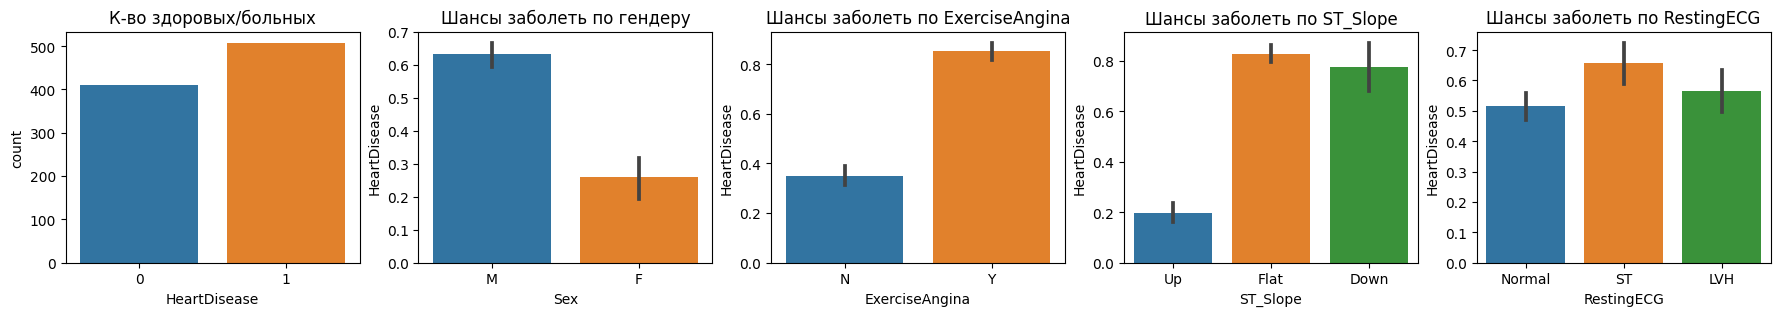

In [14]:
# Посмотрим на соотношение меток классов в HeartDisease 
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(22,3))

_ = sns.countplot(x='HeartDisease', data=df, ax=ax[0])
ax[0].set_title('К-во здоровых/больных')
_ = sns.barplot(x='Sex', y='HeartDisease', data=df, ax=ax[1])
ax[1].set_title('Шансы заболеть по гендеру')
_ = sns.barplot(x='ExerciseAngina', y='HeartDisease', data=df, ax=ax[2])

ax[2].set_title('Шансы заболеть по ExerciseAngina')
_ = sns.barplot(x='ST_Slope',y='HeartDisease',data=df, ax=ax[3])
ax[3].set_title('Шансы заболеть по ST_Slope')
_ = sns.barplot(x='RestingECG',y='HeartDisease',data=df, ax=ax[4])
ax[4].set_title('Шансы заболеть по RestingECG')

plt.show()
plt.close()

## a)Категориальные переменные переведите в цифровые значения.

In [15]:
# Категориальные features - определяем по типу object. Вместе с target их 9
cat_features = df.select_dtypes("object").columns
print(*cat_features, sep=", ")

Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope


In [16]:
num_features = df.select_dtypes(['int', 'float']).columns.tolist()
print(*num_features, sep=", ")


Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease


In [19]:
selectedColumns = df[cat_features]
encoded_features = pd.get_dummies(selectedColumns, columns=cat_features,drop_first=True)
encoded_features.head()

,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,1,1,0,0,1,0,0,0,1
1,0,0,1,0,1,0,0,1,0
2,1,1,0,0,0,1,0,0,1
3,0,0,0,0,1,0,1,1,0
4,1,0,1,0,1,0,0,0,1


In [20]:
other_features=df.loc[:, num_features].drop(columns='HeartDisease')
other_features.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
0,40,140,289,0,172,0.0
1,49,160,180,0,156,1.0
2,37,130,283,0,98,0.0
3,48,138,214,0,108,1.5
4,54,150,195,0,122,0.0


In [21]:
X = pd.concat([other_features, encoded_features], axis=1)
y=df['HeartDisease']

#3. Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

In [22]:
random_seed=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

#4. Обучите дерево решений на обучающем множестве. Используйте следующие модели:
a) tree.DecisionTreeClassifier

In [ ]:
criterias=['gini', 'entropy', 'log_loss']

In [23]:
dt = make_pipeline(
     Normalizer(),
    DecisionTreeClassifier(criterion='entropy',random_state=random_seed, 
                                        class_weight={0: pd.DataFrame(y_train).value_counts(normalize=True)[0],
                                                      1: pd.DataFrame(y_train).value_counts(normalize=True)[1]})
)
dt.fit(X_train, y_train)

Pipeline(steps=[('normalizer', Normalizer()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight={0: 0.4536784741144414,
                                                      1: 0.5463215258855586},
                                        criterion='entropy', random_state=0))])

b) ensemble.RandomForestClassifier

In [24]:
rf = RandomForestClassifier(criterion='entropy',random_state=random_seed, 
                                        class_weight={0: pd.DataFrame(y_train).value_counts(normalize=True)[0],
                                                      1: pd.DataFrame(y_train).value_counts(normalize=True)[1]})

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight={0: 0.4536784741144414,
                                     1: 0.5463215258855586},
                       criterion='entropy', random_state=0)

#5. Для тестового множества сделайте предсказание целевой переменной. Выведите метрики для каждой построенной модели с помощью metrics.classification_report.

a) tree.DecisionTreeClassifier

In [25]:
y_pred = dt.predict(X_test)
target_names = ['healthy', 'sick']
print(
    f"Classification report DecisionTreeClassifier\n")
print(
    f"{classification_report(y_test, y_pred, target_names=target_names)}\n"
)

Classification report DecisionTreeClassifier

              precision    recall  f1-score   support

     healthy       0.76      0.78      0.77        77
        sick       0.84      0.82      0.83       107

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.81      0.80      0.80       184




In [26]:
results={}
a=classification_report(y_test, y_pred, target_names=target_names, output_dict=True )['weighted avg']
results['DecisionTreeClassifier']=a

b) ensemble.RandomForestClassifier

In [27]:
y_pred = rf.predict(X_test)
target_names = ['healthy', 'sick']
print(
    f"Classification report RandomForestClassifier\n")
print(
    f"{classification_report(y_test, y_pred, target_names=target_names)}\n"
)

Classification report RandomForestClassifier

              precision    recall  f1-score   support

     healthy       0.86      0.78      0.82        77
        sick       0.85      0.91      0.88       107

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.85       184
weighted avg       0.85      0.85      0.85       184




In [28]:
a=classification_report(y_test, y_pred, target_names=target_names, output_dict=True )['weighted avg']
results['RandomForestClassifier'] = a

У RandomForestClassifier все метрики выше, чем у DecisionTreeClassifier. При этом метрики качества DecisionTreeClassifier значительно растут при использовании нормализации. На метрики качества RandomForestClassifier нормализациия, разумеется, никак не влияет

#6. Выведите важность признаков, полученную после обучения модели из п. 4b в виде столбчатой диаграммы. Отсортируйте важность по убыванию.

In [29]:
X.shape

(918, 15)

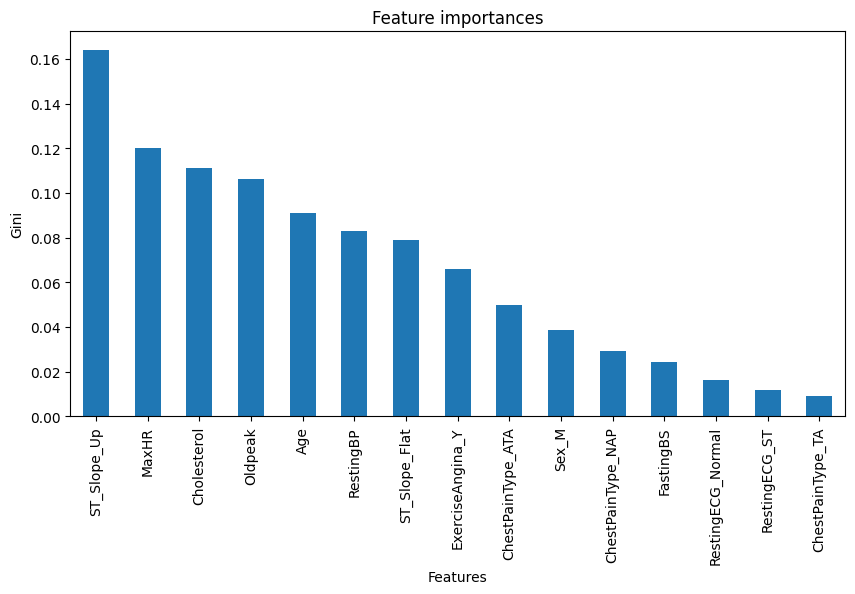

In [30]:
imp = pd.Series(rf.feature_importances_)
imp.index = pd.Series(X_train.columns)
imp = imp.sort_values(ascending=False)
plt.title('Feature importances')
plt.xlabel('Features')
plt.ylabel('Gini')
imp.plot(kind='bar',figsize=(10,5))

plt.show()

#7. Обучите бэггинг над моделью из п. 4a. Используйте ensemble.BaggingClassifier.
a) Повторите п. 5

In [31]:
bagging = BaggingClassifier(dt)
bagging.fit(X_train, y_train)

BaggingClassifier(estimator=Pipeline(steps=[('normalizer', Normalizer()),
                                            ('decisiontreeclassifier',
                                             DecisionTreeClassifier(class_weight={0: 0.4536784741144414,
                                                                                  1: 0.5463215258855586},
                                                                    criterion='entropy',
                                                                    random_state=0))]))

In [32]:
y_pred = bagging.predict(X_test)
print(f"Classification report BaggingClassifier\n")
print(f"{classification_report(y_test, y_pred, target_names=target_names)}\n")

Classification report BaggingClassifier

              precision    recall  f1-score   support

     healthy       0.80      0.79      0.80        77
        sick       0.85      0.86      0.86       107

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184




In [33]:
a=classification_report(y_test, y_pred, target_names=target_names, output_dict=True )['weighted avg']
results['BaggingClassifier'] = a

Метрики качества выше, чем у TreeDecisionClassifier, но до RandomForestClassifier не дотягивают

#8. Обучите стекинг трех моделей: из п. 4a, п. 4b и svm.LinearSVC. Используйте ensemble.StackingClassifier.
a) Повторите п. 5

In [34]:
clf = StackingClassifier(
    [
        ('DecisionTreeClassifier', dt),
        ('RandomForestClassifier', rf),
       
    ],  LinearSVC( C=1, random_state=random_seed,
                  class_weight={0: pd.DataFrame(y_train).value_counts(normalize=True)[0],
                                1: pd.DataFrame(y_train).value_counts(normalize=True)[1]}))
clf.fit(X_train, y_train)

StackingClassifier(estimators=[('DecisionTreeClassifier',
                                Pipeline(steps=[('normalizer', Normalizer()),
                                                ('decisiontreeclassifier',
                                                 DecisionTreeClassifier(class_weight={0: 0.4536784741144414,
                                                                                      1: 0.5463215258855586},
                                                                        criterion='entropy',
                                                                        random_state=0))])),
                               ('RandomForestClassifier',
                                RandomForestClassifier(class_weight={0: 0.4536784741144414,
                                                                     1: 0.5463215258855586},
                                                       criterion='entropy',
                                                       random_state=0))],
                   final_estimator=LinearSVC(C=1,
                                             class_weight={0: 0.4536784741144414,
                                                           1: 0.5463215258855586},
                                             random_state=0))

In [35]:
y_pred = clf.predict(X_test)
print(f"Classification report StackingClassifier\n")
print(f"{classification_report(y_test, y_pred, target_names=target_names)}\n")

Classification report StackingClassifier

              precision    recall  f1-score   support

     healthy       0.86      0.77      0.81        77
        sick       0.84      0.91      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184




In [36]:
a=classification_report(y_test, y_pred, target_names=target_names, output_dict=True )['weighted avg']
results['StackingClassifier'] = a

#9. Сформулируйте выводы по проделанной работе.

a) Сравните метрики построенных моделей.

In [37]:
res=pd.DataFrame.from_dict(results)
res.drop('support', axis=0, inplace=True)
res.head()

,DecisionTreeClassifier,RandomForestClassifier,BaggingClassifier,StackingClassifier
precision,0.805202,0.853499,0.831254,0.848330
recall,0.804348,0.853261,0.831522,0.847826
f1-score,0.804679,0.852091,0.831363,0.846399


Все рассмотренные в работе модели продемонстрировали неплохое качество.

Наилучшие результаты показал RandomForestClassifier. Все метрики качества (precision, recall, accuracy, f1 score - самые высокие среди всех рассмотренных моделей. Вторую позицию занимает Stacking Classifier, немного отстает Bagging Classifier, а замыкает рейтинг  TreeDecisionClassifier

b) Напишите свое мнение, какая модель наилучшая и почему.